# 从零开始AI - 认知服务 - 人脸识别

> ··· 您可以访问 [https://github.com/HaoHoo/F02AI](https://github.com/HaoHoo/F02AI) 来获得 “从零开始AI” 系列全部的内容。··· <br>
>`请以原样使用或转发，欢迎Issue，敬请PR；如果觉得有些意思，欢迎Fork，敬谢Star。` 

在“认知服务 - 计算机视觉”这一部分，我们介绍了使用Azure的认知服务、通过标准REST API来调用云端的人工智能服务，帮助我们实现有关的计算机智能视觉。

其实在计算机视觉中有一个非常重要的分类，就是关于人脸的识别。这个分类如此重要，以至于需要单独为其使用一套独立的REST API。对于我这个脸盲症患者来说，要是能像计算机一样又快又准确地记住识别人脸那就太好了。

按照Azure目前提供的人脸功能的分类，接下来我们可以尝试如下几种能力：
* [人脸检测](#FaceDetect)
* [人脸识别](#PersonIndenty)
* [表情判断](#EmotionRecognition)

和其他认知服务一样，计算机视觉也是运行在Azure的服务。为了使用Computer Vision API，您需要一个订阅密钥 (subscription key)。别担心，您可以在[这里](https://docs.microsoft.com/azure/cognitive-services/Computer-vision/Vision-API-How-to-Topics/HowToSubscribe)获取免费的订阅密钥。或者在[这里](https://azure.microsoft.com/zh-cn/try/cognitive-services)获取试用的订阅密钥。

获取订阅密钥后，请记录密钥及分配的Azure服务区域。对于测试认知服务，往往会分配美国中西区域 (WestCentralUS)。后面我们使用这些API时，必须提供这两种信息。

要开始尝试使用计算机视觉服务分析图像，需要将下列代码中 `subscription_key` 的值 ** None ** 替换为前面我们获得的API密钥。

In [1]:
subscription_key = '5b82fd7688174e06850d1951bfdd3b22'
assert subscription_key

然后，请确认以下 `vision_base_url` 显示的地址与之前申请 API 密钥的区域吻合 (`westus`, `westcentralus`, 等等)。如果使用的是免费的订阅，通常不需要修改以下的地址。

In [2]:
face_base_url = "https://westus.api.cognitive.microsoft.com/face/v1.0/"

## 使用Python调用Face API进行人脸检测 <a name="FaceDetect"> </a>

在 [Face Detect](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236) API网站，您能够直接在页面查看图像分析所支持的方法。该 API 网站非常便利，除了查阅 API 方法之外，您还可以直接尝试提供图片测试该 API。调用该API可选择使用这些参数：`faceId`，`landmarks`和`attributes`。

如果调用成功，API 将返回以下信息:
年龄(`age`)，性别(`gender`)，姿势(`headPose`)，微笑(`smile`)，美发(`facialHair`)，眼镜(`glasses`)，情感(`emotion`)，头发(`hair`)，化妆(`makeup`)，遮挡(`occlusion`)，配件(`accessories`)，模糊(`blur`)，曝光(`exposure`)和噪声(`noise`)。
不需要全部信息的时候，`attibutes`可以指定返回的上述信息。

照片放在微软的云端，会不会侵犯隐私？可以放心的是，存放的是提取的面部特征而不是实际图像。前面提及的`faceId`就是面部特征的标识符，它将用于各类人脸功能，并在API调用后24小时过期。

In [3]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import requests

先来一个有意思的人脸检测的实验：您有信心一眼看出几十人的合影中，有多少男性、多少女性吗？让我们找一张合影尝试一下。

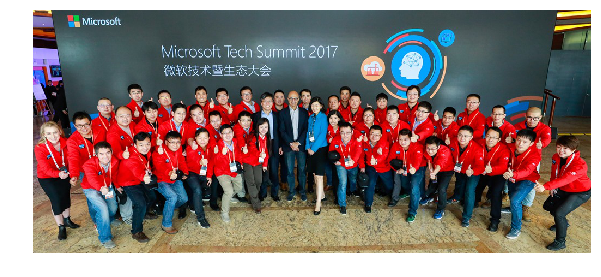

In [4]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/mvp-l.jpeg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.figure(figsize=(10,10))
plt.imshow(image)
_ = plt.axis("off")

在我们还没有数完有多少个人头的时候，人工智能已经完成了所有人脸的检测分析。简单的代码，就能够把女性使用紫色、男性使用蓝色标记出来。当然，以下的代码只是显示处理之后的照片。

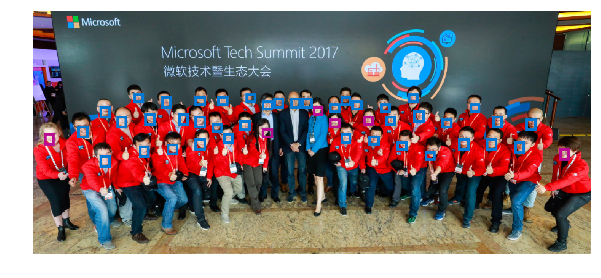

In [5]:
image_url = "https://github.com/HaoHoo/F02AI/raw/master/N02/images/Face/mvp-d.png"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.figure(figsize=(10,10))
plt.imshow(image)
_ = plt.axis("off")

### 分析图像

人脸检测的URL调用链接形如以下的例子 (可以在[这里](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236)查看REST API文档):

<code>https://[location].api.cognitive.microsoft.com/face/v1.0/<b>detect</b>[?returnFaceId][&returnFaceLandmarks][&returnFaceAttributes][&recognitionModel][&returnRecognitionModel]</code>

所以URL后面调用的功能先设置为 `detect`。

In [ ]:
face_detect_url = face_base_url + "detect"

要开始分析图像，我们需要提供一张图片的URL给 `image_url` 变量。当然，您也可以把照片的URL改为您期望的地址。

In [ ]:
image_url = "https://downtrend.com/wp-content/uploads/2018/06/twa2.jpg"

我们先用代码看看原始照片。通过在notebook中使用“魔术”代码，可以在线导入matplotlib来进行画图。我们就用这个库来”画“出提供的照片。

In [ ]:
%matplotlib inline
from PIL import Image
from io import BytesIO
import requests
import matplotlib.pyplot as plt
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

为了通过 REST 方式调用人脸检测的 `detect` API，接下来的代码块需要使用 Python 的 `requests` 库。API 调用的结果将以 JSON 对象返回。按照规范，变量 `headers` 使用一个 dictionary 类型来包含必要的 API 密钥信息。而变量 `params` 同样使用 dictionary 类型来定义要调用的可视化功能。所有支持的功能都可以访问 [REST API 文档](https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395236)查看。

接着就可以通过 `requests` 来调用 REST 并返回 JSON 形式的结果了。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceAttributes': 'age,gender,smile,facialHair,glasses,emotion,\
hair,makeup,occlusion,accessories,blur,exposure,noise',
            'recognitionModel': 'recognition_02'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()

让我们来看一下人脸检测功能成功运行之后，返回了什么信息。

In [ ]:
print(analysis)

可以看到，人脸检测识别出了照片中的人脸，并且给出了一些关于人脸的信息。例如，人脸检测判断说这是一位58岁的男性，金发，没戴眼镜。并且还发现了Trump在笑。让我们再来一张照片，来比较一下返回的信息差异～

In [ ]:
image_url = "http://news.eastday.com/w/20140314/images/02468061.jpg"

当然，您也可以把上面的照片链接换成您喜欢的。在使用人脸检测功能之前，我们先显示一下这张照片。

In [ ]:
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

然后我们跟前一张照片一样，调用人脸检测功能来看看返回的信息。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceAttributes': 'age,gender,smile,facialHair,glasses,emotion,\
hair,makeup,occlusion,accessories,blur,exposure,noise',
            'recognitionModel': 'recognition_02'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
print(analysis)

这一次返回的信息有所不同。首先，人脸检测判断这是位42岁的男性，戴了眼镜。我们还看到，Kim Jeong-eun同志比较严肃，没有笑。

那么，Azure中的人脸检测服务是如何识别人脸以及其他信息的呢？

实际上，计算机对人脸上的27个特征点进行了标记。利用这些特征点，计算机能够识别出这是否是人脸，并且，对照这些特征点的相对位置，计算机通过机器学习，就能够识别人脸的表情。在后面的实验，我们会单独介绍表情识别。

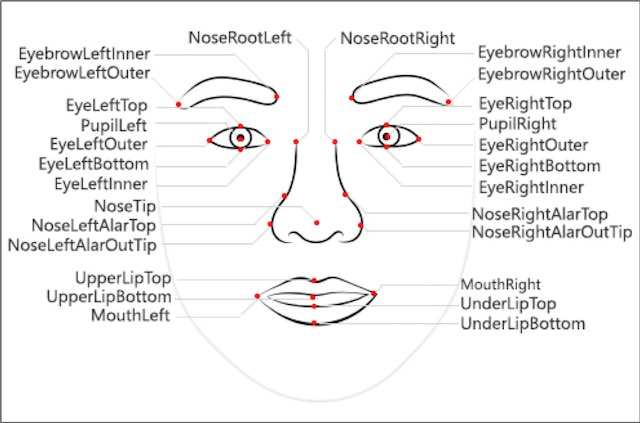

我们可以来尝试获得一下这些特征点。还是一样，我们找一张照片。

In [ ]:
image_url = "http://p.ananas.chaoxing.com/star2/2014-06/1024_0c/1403711159370jpizg.jpg"
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)

如人脸检测的REST API文档描述，我们需要构造调用的HTTP头部信息和参数，然后使用服务终结点URL来POST数据，再处理返回的数据。

In [ ]:
headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
params   = {'returnFaceLandmarks': 'true'}
data     = {'url': image_url}
response = requests.post(face_detect_url, headers=headers, params=params, json=data)
response.raise_for_status()
analysis = response.json()
print(analysis)

让我们把人脸检测识别的面部区域和面部特征的27个点的坐标从JSON数据中筛选出来。

In [ ]:
detect_face = analysis[0]["faceRectangle"]
print(detect_face)
points_face = analysis[0]["faceLandmarks"]
print(points_face)

数据看起来很乱对吧？让我们把数据整理一下。

In [ ]:
import pandas as pd
df = pd.DataFrame(points_face).T
print(df)

接下来，我们把这些数据画到照片上，方便对照查看。

In [ ]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(7,7))
ax     = plt.imshow(image, alpha=0.7)
origin = (detect_face["left"], detect_face["top"])
p      = Rectangle(origin, detect_face["width"], detect_face["height"], fill=False, linewidth=2, color='blue')
ax.axes.add_patch(p)
plt.scatter(df.x, df.y, s=5, c='navy')
_ = plt.axis("off")

## 人脸识别 <a name="FaceIdentity"> </a>

通过人脸检测的实验，我们初步了解了对于人脸的机器视觉功能的原理——基于27的特征点来对人脸图像进行分析。既然每张面孔都可以通过这些特征点来描述，那是否可以将这个技术用于进行人脸识别呢？

答案当然是可以的。不过，要识别人脸比检测人脸就稍微复杂一点。因为我们需要对照保存的人脸图片和需要比较的人脸图片——如同我们在一些应用中使用人脸识别功能一样，首先我们需要提供几张人脸的照片给到计算机，进行特征识别并保存，然后才能将需要识别的人脸图片与之相对照。因此，我们必须将图片先发送给Face API并关联到人，保存这些信息用于后面的识别。

还记得前面我们介绍的FaceID吗？我们需要使用FaceID来关联这些保存的面部信息。而为了对人脸进行识别，就必须为每一个人分析几张人脸的照片。所以，我们就需要有一种组织形式，将人脸图片和人联系在一起，将人按照组进行组织。

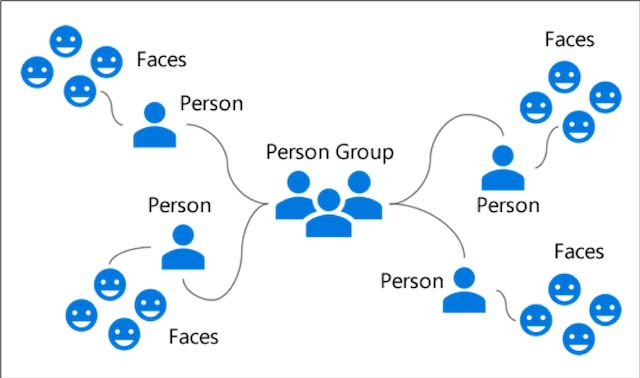

一对多识别将从人员组或大型人员组中找到特定查询人脸的最接近的匹配。

为了进行人脸识别，首先我们需要将一组人组织为一个人员组或大型人员组，随着组的创建，按照组的规模大小，也就产生了唯一的`personGroupId`或`largePersonGroupId`。接下来，我们需要将每个人的不超过248张面部照片进行采样保存，然后每次可以对不超过10张面部图片进行识别。更高的面部图像质量意味着更好的识别精度，请考虑高质量的脸部：正面，清晰，脸部大小为200x200像素（眼睛间为100像素）或更大。返回的候选人数受`maxNumOfCandidatesReturned`和`confidenceThreshold`的限制。如果没有人被识别，则返回的候选人将是一个空阵列。

对于`faceIds`数组中的每个面，人脸识别将计算查询面与人员组中的所有面部（由`personGroupId`给出）或大型人员组（由`largePersonGroupId`给出）之间的相似性，并返回该面部的候选人相似可信排名。应训练人员组/大型人员组，以便为人脸识别做好准备。可在<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395249">PersonGroup-Train</a>及<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/599ae2d16ac60f11b48b5aa4">LargePersonGroup-Train</a>文档中查看更多信息。

当您需要从面部列表/大型面部列表而不是人员组/大型人员组中查找相似的面部时，尝试<a href="https://westus.dev.cognitive.microsoft.com/docs/services/563879b61984550e40cbbe8d/operations/563879b61984550f30395237">Face-Find Similar</a>，<a name="FindSimilar">查找近似人脸</a>。

一口气说了这么多，接下来我们尝试通过一系列的实验步骤，提供几位为人熟知的人的面部照片并加以训练，然后再尝试使用其他照片进行人脸的识别。

首先，我们需要创建一个人员组。

In [ ]:
personGroupId = 'MSFT-VIP'
person_add_url=face_base_url+"/face/v1.0/persongroups/"+ personGroupId +"/persons"

personName = "Satya Nadella"
body = {"name": personName, "userData":"Microsoft Global CEO"}
response = requests.post(person_add_url, headers=headers, params=params, json=body)
response.raise_for_status()
analysis = response.json()
print(personName,'\npersonID:\n'+analysis.get("personId")+'\nfaceID:')

